In [1]:
import os
import sys

if os.path.abspath('../..') not in sys.path:
    sys.path.append(os.path.abspath('../..'))
    
import json
import shutil
import datetime

from dateutil.relativedelta import relativedelta
import tqdm

import scipy
import scipy.stats as st
from scipy.spatial import distance
from scipy.stats import mannwhitneyu, wilcoxon

import numpy as np
import pandas as pd

from sqlalchemy.orm.exc import NoResultFound

from src.corpus import load_tweets
from src.dataset import load_dataset 
from src.config import config
from src.utils.backup import FileBackup
from src.dashboard.models import db, Collection, CollectionTopicProba, Document, TopicModelLoader, Topic, Subject
from src.dashboard.app import app

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
POSITIONS_MAP = {
    'Meteorologist': 'Meteorologist',
    'Reporter': 'Reporter',
    'Producer': 'Reporter',
    'Journalist': 'Reporter',
    'Editor': 'Reporter',
    'Other': 'Other',
    'Student': 'Other',
    'Academic': 'Other',
    'Met Producer': 'Meteorologist',
    'News Director': 'Reporter',
    'Vice President': 'Reporter', 
    'Photographer': 'Reporter'
}

In [3]:
with app.app_context():
    model_loader = None
    for model_loader in TopicModelLoader.query.all():
        if (model_loader.model.num_epochs, model_loader.model.num_topics) == (1, 6):
            break
    cs = Collection.query.all()
    data, tuples = [], []
    for c in tqdm.tqdm(cs, desc='Collecting Collection Probabilities'):
        topics = c.get_topic_dist(model_loader)
        num_docs = len(c.documents)
        proba_sum = 0
        for t in topics:
            proba_sum += t.proba
        if c.subject is None:
            continue
        event_id = 'None'
        event_type = 'None'
        if c.event:
            event_id = c.event.id
            event_type = c.event.event_type
        groups = c.group.split('-')
        index = 0
        try:
            index = int(groups[-1])
            group = '-'.join(groups[:-1])
        except ValueError as ex:
            group = '-'.join(groups)
        tuples += [(c.id, c.type, group, index, c.subject_id, event_id, event_type, POSITIONS_MAP[c.subject.position], num_docs)]
        data.append({topic_proba.topic.label: topic_proba.proba for i, topic_proba in enumerate(topics)})
    index = pd.MultiIndex.from_tuples(tuples, names=['id', 'type', 'group', 'index', 'subject_id', 
                                                     'event_id', 'event_type', 'position', 'num_docs'])
    df = pd.DataFrame.from_records(data)
    df.index = index
    relevant_topics = Topic.query.filter(
        Topic.topic_model_loader_id == model_loader.id,
        Topic.is_relevant.is_(True),
    ).all()

In [4]:
df.columns

Index(['Topic 1 - Emissions/Gas', 'Topic 2 - Energy/Cliamate/Oil/Gas',
       'Topic 3 - Forecast', 'Topic 4 - Forecast', 'Topic 5 - Forecast/Strom',
       'Topic 6 - Gas/Extreme'],
      dtype='object')

In [5]:
relevant_topics_cols = ['Topic 1 - Emissions/Gas', 'Topic 2 - Energy/Cliamate/Oil/Gas']

In [6]:
def index_filter(df, **kwargs):
    filters = None
    for key, value in kwargs.items():
        item_filter = df.index.get_level_values(key) == value
        if filters is None:
            filters = item_filter
        else:
            filters = filters & item_filter
    return filters

Event Type:  Join
Number of subjects:  732
w:  39737.0 , P-value:  0.00040266894875465266 Reject null hypothesis
Average relevance probability (Before event) 0.07392542102081258
Average relevance probability (After event) 0.0909173600517259
Increment:  22.99%

Event Type:  Workshop
Number of subjects:  24
w:  45.0 , P-value:  0.6811166505361984 Accept null hypothesis
Average relevance probability (Before event) 0.14445157205458484
Average relevance probability (After event) 0.11792937463572524
Increment:  -18.36%

Event Type: All
Number of subjects:  738
w:  42420.0 , P-value:  0.0006670246522200679 Reject null hypothesis
Average relevance probability (Before event) 0.07615843899549665
Average relevance probability (After event) 0.09177262172720874
Increment:  20.50%


/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


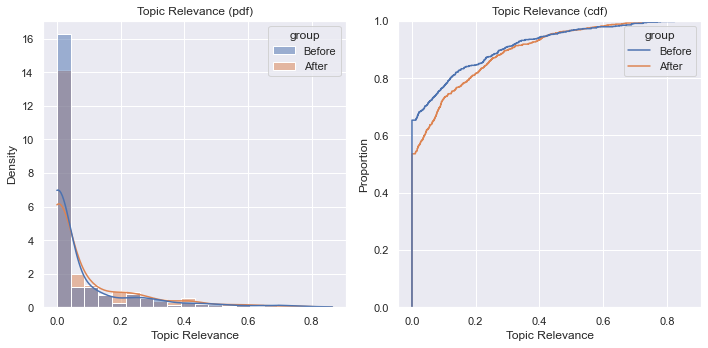

In [7]:
data_df = df[index_filter(df, type='intra-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

data_df = data_df[data_df['Position'] == 'Meteorologist']

no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

data_df = data_df[data_df.group_y].drop('group_y', axis=1)

for event_type in data_df['Event Type'].unique():
    print('Event Type: ', event_type)
    event_df = data_df[data_df['Event Type'] == event_type]
    before_df = event_df[event_df['group'] == 'Before'].set_index(['subject_id', 'event_id'])
    num_subjects = len(before_df.index.get_level_values('subject_id').unique())
    before_s = before_df['Topic Relevance']
    after_df = event_df[event_df['group'] == 'After'].set_index(['subject_id', 'event_id'])
    after_df = after_df.loc[before_df.index, :]
    after_s = after_df['Topic Relevance']
    w, p = wilcoxon(after_s, before_s, alternative='greater')
    print('Number of subjects: ', num_subjects)
    print('w: ', w, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')
    # U1, p = mannwhitneyu(after_s, before_s, alternative='greater')
    # print('U:', U1, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')
    bm, am = before_s.mean(), after_s.mean()
    print('Average relevance probability (Before event)', bm)
    print('Average relevance probability (After event)', am)
    print('Increment: ', '{:0.2f}%'.format((am - bm) * 100 / (bm)))
    print()

print('Event Type: All')
before_df = data_df[data_df['group'] == 'Before'].set_index(['subject_id', 'event_id'])
before_s = before_df['Topic Relevance']
num_subjects = len(before_df.index.get_level_values('subject_id').unique())
after_df = data_df[data_df['group'] == 'After'].set_index(['subject_id', 'event_id'])
after_df = after_df.loc[before_df.index, :]
after_s = after_df['Topic Relevance']
w, p = wilcoxon(after_s, before_s, alternative='greater')
print('Number of subjects: ', num_subjects)
print('w: ', w, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')
bm, am = before_s.mean(), after_s.mean()
print('Average relevance probability (Before event)', bm)
print('Average relevance probability (After event)', am)
print('Increment: ', '{:0.2f}%'.format((am - bm) * 100 / (bm)))

fig, axs = plt.subplots(ncols=2)

fig.set_size_inches(10, 5)

ax = axs[0]
sns.histplot(data_df, x='Topic Relevance', bins=20, hue='group', stat='density', kde=True, common_norm=False, ax=ax)
ax.set_title('Topic Relevance (pdf)')

ax = sns.ecdfplot(data=data_df, x='Topic Relevance', hue='group', ax=axs[1])
ax.set_title('Topic Relevance (cdf)')

fig.tight_layout()
plt.savefig('intra-subject-topic-relevance.png', bbox_inches='tight')

Total number of participants 738
Participant        463
Non-Participant    463
Name: Group, dtype: int64
U:  116910.0 , P-value:  0.008193556997790615 Reject null hypothesis
Average relevance probability (Non-Participant event) 0.1409792519770531
Average relevance probability (Participant event) 0.15461241789664895
Increment:  9.67%


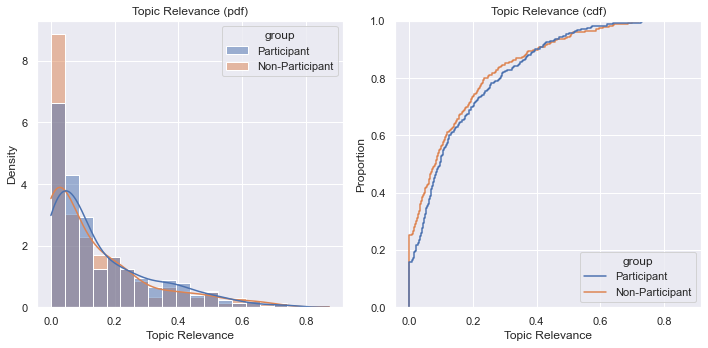

In [8]:
data_df = df[index_filter(df, type='intra-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

data_df = data_df[data_df['Position'] == 'Meteorologist']

no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

data_df = data_df[data_df.group_y].drop('group_y', axis=1)

participant_ids_s = data_df['subject_id'].unique()

print('Total number of participants', len(participant_ids_s))

fig_df = df[index_filter(df, type='inter-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

fig_df = fig_df.assign(Group=fig_df['group'])
fig_df = fig_df.assign(Position=fig_df['position'].map(POSITIONS_MAP))

fig_df = fig_df[fig_df['event_type'] == 'None']
fig_df = fig_df[fig_df['Position'] == 'Meteorologist']

non_participants_df = fig_df[fig_df['Group'] == 'Non-Participant']

participants_df = fig_df[fig_df['subject_id'].isin(participant_ids_s)].sample(non_participants_df.shape[0])

fig_df = pd.concat([participants_df, non_participants_df], ignore_index=True)

print(fig_df['Group'].value_counts())

participant_s = participants_df['Topic Relevance']
non_participant_s = non_participants_df['Topic Relevance']

U1, p = mannwhitneyu(participant_s, non_participant_s, alternative='greater')
print('U: ', U1, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')
bm, am = non_participant_s.mean(), participant_s.mean()
print('Average relevance probability (Non-Participant event)', bm)
print('Average relevance probability (Participant event)', am)
print('Increment: ', '{:0.2f}%'.format((am - bm) * 100 / (bm)))

fig, axs = plt.subplots(ncols=2)

fig.set_size_inches(10, 5)

ax = axs[0]
sns.histplot(fig_df, x='Topic Relevance', bins=20, hue='group', stat='density', kde=True, common_norm=False, ax=ax, hue_order=['Participant', 'Non-Participant'])
ax.set_title('Topic Relevance (pdf)')

ax = sns.ecdfplot(data=fig_df, x='Topic Relevance', hue='group', ax=axs[1], hue_order=['Participant', 'Non-Participant'])
ax.set_title('Topic Relevance (cdf)')

fig.tight_layout()
plt.savefig('inter-subject-topic-relevance.png', bbox_inches='tight')

In [9]:
relevant_topics_cols

['Topic 1 - Emissions/Gas', 'Topic 2 - Energy/Cliamate/Oil/Gas']

U:  325748.5 , P-value:  3.9739762308377797e-07 Reject null hypothesis
Average consistency (Before event) 0.4141387797213188
Average consistency (After event) 0.5671637702391044
Increment:  36.95%


/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


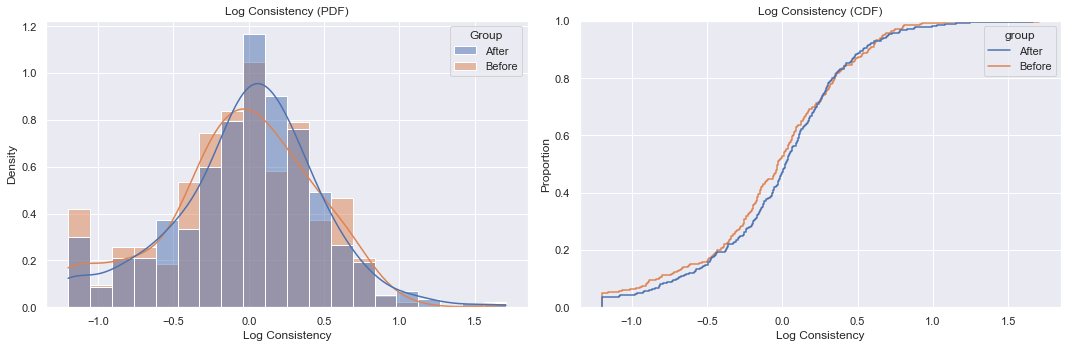

In [17]:
data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

# data_df = data_df[data_df.std(axis=1) > 0]
consistency_df = data_df.mean(axis=1) / data_df.std(axis=1) 
consistency_df = consistency_df.fillna(0.0)

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']
sub_fig_df = sub_fig_df.assign(Position=sub_fig_df['position'].map(POSITIONS_MAP))
sub_fig_df = sub_fig_df[sub_fig_df['Position'] == 'Meteorologist']

after_s = sub_fig_df[sub_fig_df['Group']=='After']['Consistency']
before_s = sub_fig_df[sub_fig_df['Group']=='Before']['Consistency']

U1, p = mannwhitneyu(after_s, before_s, alternative='greater')
print('U: ', U1, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')

bm, am = before_s.mean(), after_s.mean()
print('Average consistency (Before event)', bm)
print('Average consistency (After event)', am)
print('Increment: ', '{:0.2f}%'.format((am - bm) * 100 / (bm)))

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

ax = axs[0]

sub_fig_df['Log Consistency'] = np.log(sub_fig_df['Consistency'])

sns.histplot(sub_fig_df, x='Log Consistency', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=ax,
                hue_order=['After', 'Before'])
# ax.axvline(x=after_s.mean(), color='blue', ls='--', lw=2.5)
# ax.axvline(x=before_s.mean(), color='orange', ls='--', lw=2.5)
ax.set_title('Log Consistency (PDF)')

ax = sns.ecdfplot(data=sub_fig_df, x='Log Consistency', hue='group', ax=axs[1], hue_order=['After', 'Before'])
ax.set_title('Log Consistency (CDF)')

fig.tight_layout()
plt.savefig('intra-subject-log-consistency.png', bbox_inches='tight')

<AxesSubplot:xlabel='num_docs', ylabel='Count'>

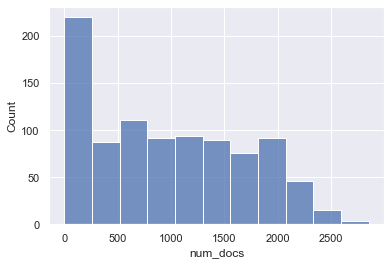

In [11]:
sns.histplot(fig_df['num_docs'])

In [12]:
data_df = df[index_filter(df, type='inter-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

data_df

index                                                                                            1   \
type                      group           subject_id    event_id event_type position                  
inter-subject-consistency Non-Participant 5440709145    None     None       Meteorologist  0.000000   
                                          6947401587    None     None       Meteorologist  0.676868   
                                          9461884617    None     None       Meteorologist  0.000000   
                                          10964728052   None     None       Meteorologist  0.055729   
                                          12266948130   None     None       Meteorologist  0.102306   
...                                                                                             ...   
                          Participant     1098083976717 None     None       Meteorologist  0.000000   
                                          1098098613861 None     None       Meteorologist  0.000000   
                                          1098221785740 None     None       Meteorologist  0.311547   
                                          1098881129152 None     None       Meteorologist  0.020736   
                                          1099010156219 None     None       Meteorologist  0.000000   

index                                                                                            2   \
type                      group           subject_id    event_id event_type position                  
inter-subject-consistency Non-Participant 5440709145    None     None       Meteorologist  0.000000   
                                          6947401587    None     None       Meteorologist  0.571682   
                                          9461884617    None     None       Meteorologist  0.000000   
                                          10964728052   None     None       Meteorologist  0.000000   
                                          12266948130   None     None       Meteorologist  0.000000   
...                                                                                             ...   
                          Participant     1098083976717 None     None       Meteorologist  0.000000   
                                          1098098613861 None     None       Meteorologist  0.000000   
                                          1098221785740 None     None       Meteorologist  0.014192   
                                          1098881129152 None     None       Meteorologist  0.156741   
                                          1099010156219 None     None       Meteorologist  0.000000   

index                                                                                            3   \
type                      group           subject_id    event_id event_type position                  
inter-subject-consistency Non-Participant 5440709145    None     None       Meteorologist  0.000000   
                                          6947401587    None     None       Meteorologist  0.000000   
                                          9461884617    None     None       Meteorologist  0.000000   
                                          10964728052   None     None       Meteorologist  0.121383   
                                          12266948130   None     None       Meteorologist  0.000000   
...                                                                                             ...   
                          Participant     1098083976717 None     None       Meteorologist  0.000000   
                                          1098098613861 None     None       Meteorologist  0.000000   
                                          1098221785740 None     None       Meteorologist  0.092408   
                                          1098881129152 None     None       Meteorologist  0.000000   
                                          1099010156219 None     None       Meteorol

U:  187602.0 , P-value:  0.538278715908849 Accept null hypothesis
Average consistency (Non-Participant) 1.0299558546391008
Average consistency (Participant) 1.0105024156489057
Increment:  -1.89%


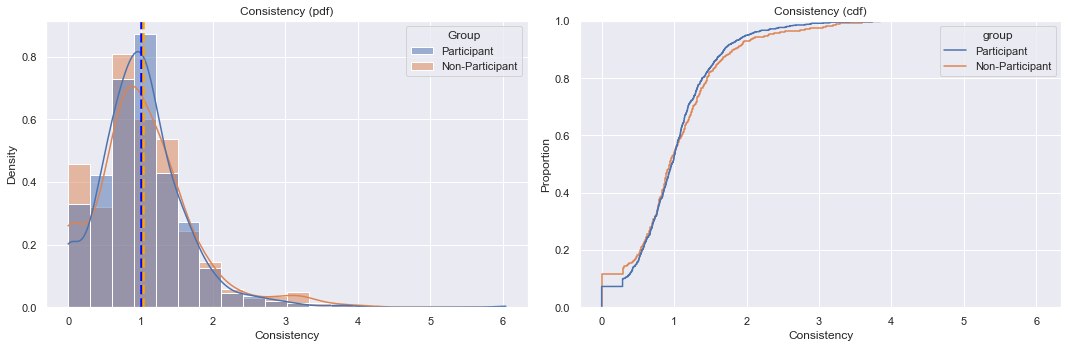

In [13]:
data_df = df[index_filter(df, type='inter-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

# data_df = data_df[data_df.std(axis=1) > 0]
consistency_df = data_df.mean(axis=1) / data_df.std(axis=1) 
consistency_df = consistency_df.fillna(0.0)

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']
sub_fig_df = sub_fig_df.assign(Position=sub_fig_df['position'].map(POSITIONS_MAP))
sub_fig_df = sub_fig_df[sub_fig_df['Position'] == 'Meteorologist']

participant_s = sub_fig_df[sub_fig_df['Group']=='Participant']['Consistency']
non_participant_s = sub_fig_df[sub_fig_df['Group']=='Non-Participant']['Consistency']

U1, p = mannwhitneyu(participant_s, non_participant_s, alternative='greater')
print('U: ', U1, ', P-value: ', p, 'Reject null hypothesis' if p < 0.05 else 'Accept null hypothesis')

bm, am = non_participant_s.mean(), participant_s.mean()
print('Average consistency (Non-Participant)', bm)
print('Average consistency (Participant)', am)
print('Increment: ', '{:0.2f}%'.format((am - bm) * 100 / (bm)))

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

ax = axs[0]

sns.histplot(sub_fig_df, x='Consistency', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=ax,
                hue_order=['Participant', 'Non-Participant'])
# ax.axvline(x=participant_s.mean(), color='blue', ls='--', lw=2.5)
# ax.axvline(x=non_participant_s.mean(), color='orange', ls='--', lw=2.5)
ax.set_title('Consistency (pdf)')

ax = sns.ecdfplot(data=sub_fig_df, x='Consistency', hue='group', ax=axs[1], hue_order=['Participant', 'Non-Participant'])
ax.set_title('Consistency (cdf)')

fig.tight_layout()
plt.savefig('inter-subject-consistency.png', bbox_inches='tight')